[参考ページ](https://github.com/takitsuba/midoribon/blob/master/Chap6/Chap6.ipynb)

In [1]:
import seaborn as sns; sns.set(font="IPAexGothic")
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib
print(sns.__version__)

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

np.random.seed(1000)

d = pd.read_csv("data4a.csv",dtype={"y": int,"x":float, "f":"category"})

0.9.0


In [2]:
d.head()

,N,y,x,f
0,8,1,9.76,C
1,8,6,10.48,C
2,8,5,10.83,C
3,8,6,10.94,C
4,8,1,9.37,C


In [3]:
#観測数N y生存数 x体サイズ f肥料

In [4]:
d.describe()

,N,y,x
count,100.0,100.000000,100.000000
mean,8.0,5.080000,9.967200
std,0.0,2.743882,1.088954
min,8.0,0.000000,7.660000
25%,8.0,3.000000,9.337500
50%,8.0,6.000000,9.965000
75%,8.0,8.000000,10.770000
max,8.0,8.000000,12.440000


In [5]:
d.f.describe()

count     100
unique      2
top         T
freq       50
Name: f, dtype: object

In [6]:
d.f

0     C
1     C
2     C
3     C
4     C
     ..
95    T
96    T
97    T
98    T
99    T
Name: f, Length: 100, dtype: category
Categories (2, object): [C, T]

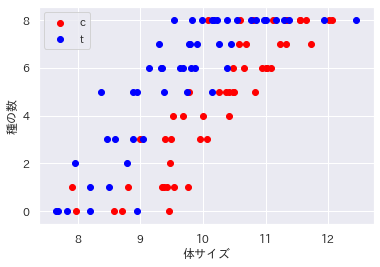

In [7]:
x_c = d.x[d.f == "C"]
y_c = d.y[d.f == "C"]

x_t = d.x[d.f == "T"]
y_t = d.y[d.f == "T"]

plt.scatter(x_c,y_c,c="red",label="c")
plt.scatter(x_t,y_t,c="blue",label="t")
plt.ylabel('種の数')
plt.xlabel('体サイズ')
plt.legend()
plt.show()

体サイズ$x_i$が大きくなると、生存種子数$y_i$は多くなりそうだ  
肥料をやる（$f_i = T$)と、生存種子数$y_i$は多くなりそうだ

# ロジスティクス回帰

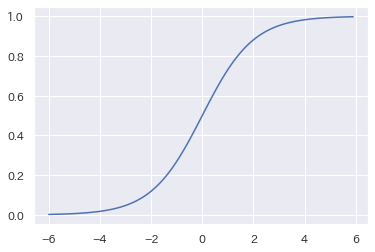

In [8]:
def sigmoid(x):
    return 1 /(1+np.exp(-x))
x = np.arange(-6,6,0.1)
y = sigmoid(x)
plt.plot(x,y)

In [9]:
model = smf.glm('y + I(N-y)~ x + f',data=d,family=sm.families.Binomial())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -133.11
Date:                Tue, 17 Sep 2019   Deviance:                       123.03
Time:                        10:32:44   Pearson chi2:                     109.
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.5361      1.414    -13.818      0.000     -22.307     -16.765
f[T.T]         2.0215      0.231      8.740      0.000       1.568       2.475
x              1.9524      0.139     14.059      0.000       1.680       2.225
==============================================================================
"""

# stan 

In [10]:
import pystan
code = """
data { 
    int<lower=0> N;
    real X[N];
    int<lower=0,upper=1> f[N];
    int<lower=0> y[N];
} 
parameters {
    real<lower=0, upper=1> p;
} 
model {
    for (i in 1:N)
        y[N] ~ binomial(N,p);
}
"""

In [11]:
import pystan
code = """
data { 
    int<lower=0> N;
    real X[N];
    int<lower=0,upper=1> f[N];
    int<lower=0> y[N];
} 
parameters {
    real beta1;
    real beta2;
}
transformed parameters{
    vector[N] theta;
    for(n in 1:N)
        theta[n] = inv_logit(X[n]*beta1+f[n]*beta2);
}
model {
    y ~ bernoulli(theta);
}
"""

url(https://www.slideshare.net/simizu706/stan-64926504)
参考になるかも

In [12]:
dstan = d.copy()
dstan = dstan.replace('C',int(0))
dstan = dstan.replace('T',int(1))
dstan.describe()

,N,y,x,f
count,100.0,100.000000,100.000000,100.000000
mean,8.0,5.080000,9.967200,0.500000
std,0.0,2.743882,1.088954,0.502519
min,8.0,0.000000,7.660000,0.000000
25%,8.0,3.000000,9.337500,0.000000
50%,8.0,6.000000,9.965000,0.500000
75%,8.0,8.000000,10.770000,1.000000
max,8.0,8.000000,12.440000,1.000000


In [19]:
dat = {'N': dstan.shape[0], 'X': dstan['x'], 'f': dstan['f'], 'y': dstan['y']}

In [22]:
# PyStan用のコードを使ってy = β0 + β1x + β2f のモデルを定義
model1 = """
   data {
       int<lower=0> J;
       int<lower=0> N[J];
       int<lower=0> y[J];
       real<lower=0> x[J];
       real<lower=0> f[J];
   }
   parameters {
       real beta_0;
       real beta_1x;
       real beta_2f;
   }
   model {
       beta_0 ~ normal(0, 100);
       beta_1x ~ normal(0, 100);
       beta_2f ~ normal(0, 100);
       for (i in 1:J) {
           y[i] ~ binomial(8, inv_logit(beta_0 * beta_1x * x[i] + beta_2f * f[i]));
       }
   }
   """
#y[i] ~ binomial(8, inv_logit(beta_0 + beta_1 * x[i] + beta_2 * f[i]));
#8個とってみてどうなったか

In [23]:
dat = {'J': dstan.shape[0], 'N': dstan['N'],'x': dstan['x'], 'f': dstan['f'], 'y': dstan['y']}

#モデル作成
%time model1 = pystan.StanModel(model_code=model1)
#サンプリング実行
%time fit = model1.sampling(data=dat)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_78656e521c0d04d1b04c2b3a1e847ab2 NOW.


Wall time: 1min


Wall time: 10 s


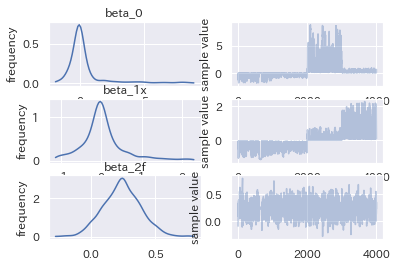

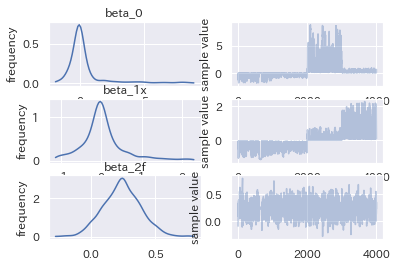

In [24]:
fit.plot()

In [25]:
fit

Inference for Stan model: anon_model_78656e521c0d04d1b04c2b3a1e847ab2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_0    0.34    0.66   1.53   -1.2  -0.25-9.1e-3   0.28   5.77      5   1.33
beta_1x   0.05    0.29   0.55  -0.93  -0.21-7.0e-3    0.2    1.6      4   1.53
beta_2f   0.24  4.9e-3   0.14  -0.04   0.14   0.24   0.33   0.53    878    1.0
lp__    -511.0    0.03   1.07 -513.8 -511.3 -510.6 -510.2 -509.9   1093    1.0

Samples were drawn using NUTS at Tue Sep 17 10:39:08 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [26]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -133.11
Date:                Tue, 17 Sep 2019   Deviance:                       123.03
Time:                        10:41:27   Pearson chi2:                     109.
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.5361      1.414    -13.818      0.000     -22.307     -16.765
f[T.T]         2.0215      0.231      8.740      0.000       1.568       2.475
x              1.9524      0.139     14.059      0.000       1.680       2.225
==============================================================================
"""

In [28]:
%%html
<style>
table {float:left}
</style>

glm

| 　 | coef | std |
|---|:---:|---:|
|x|1.9524|0.139|
|f|2.02|0.232|
|b|-19.53|1.414|



stan

| 　 | coef | std |
|---|:---:|---:|
|x|0.05|0.55|
|f|0.24|0.14|
|b|0.34|1.53|
